### References
- https://keras.io/examples/vision/autoencoder/


In [9]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from skimage import metrics
from keras import layers
from keras.datasets import mnist
from keras.models import Model

def preprocess(array):
    """Normalizes the supplied array and reshapes it."""
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array


def noise(array, lam):
    """Use poisson noise lambda"""
    array = np.random.poisson(array * lam) / lam
    return array



def display(array1, array2, array3=[]):
    """Displays ten random images from each array."""
    n = 10
    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]
    images3 =  [None] * n

    plt.figure(figsize=(20, 4))
    if len(array3) > 0:
        images3 = array3[indices, :]
        plt.figure(figsize=(20, 6))

    for i, (image1, image2, image3) in enumerate(zip(images1, images2, images3)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(64, 64))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        img2arg = 2
        if image3 is not None:
            img2arg = 3
        ax = plt.subplot(img2arg, n, i + 1 + n)
        plt.imshow(image2.reshape(64, 64))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if image3 is not None:
            ax = plt.subplot(2, n, i + 1 + n)
            plt.imshow(image3.reshape(64, 64))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

def calculate_similarity(src, dst):
    # Squeeze out the third dimension if it's 1
    if src.shape[-1] == 1:
        src = np.squeeze(src, axis=-1)
    if dst.shape[-1] == 1:
        dst = np.squeeze(dst, axis=-1)
    ssim_score = metrics.structural_similarity(src, dst, data_range=src.max() - src.min())
    return ssim_score

 

### Denoising Functions

In [8]:

MAX_KERNEL_LENGTH = 31

def apply_mean_filter(src):
  dst = cv.blur(src, (MAX_KERNEL_LENGTH, MAX_KERNEL_LENGTH))
  return dst
    

def apply_gaussian_blur(src):
  dst = cv.GaussianBlur(src, (MAX_KERNEL_LENGTH, MAX_KERNEL_LENGTH), 0)
  return dst
  

def apply_median_filter(src):
  # Convert the image to grayscale and uint8 if necessary
  src = 255 * src # Now scale by 255
  src = src.astype(np.uint8)

  dst = cv.medianBlur(src, MAX_KERNEL_LENGTH)

  # convert back to float32
  dst = dst.astype(np.float32) / 255.0


  return dst


def apply_bilateral_filter(src):

  src = 255 * src # Now scale by 255
  src = src.astype(np.uint8)

  dst = cv.bilateralFilter(src.astype(np.uint8), MAX_KERNEL_LENGTH, MAX_KERNEL_LENGTH * 2, MAX_KERNEL_LENGTH / 2)

  # convert back to float32
  dst = dst.astype(np.float32) / 255.0
 
  
  return dst


### Helper functions for calculating average SSIM scores

In [7]:
def get_average_score(test_data, apply_fn):
    score = 0
    images = []
    for i in range(len(test_data)):
      img = apply_fn(test_data[i])
      images.append(img)
      score += calculate_similarity(test_data[i], img)

    return (score / len(test_data), np.array(images))



Importing images...
Finished importing train images
Finished importing test images


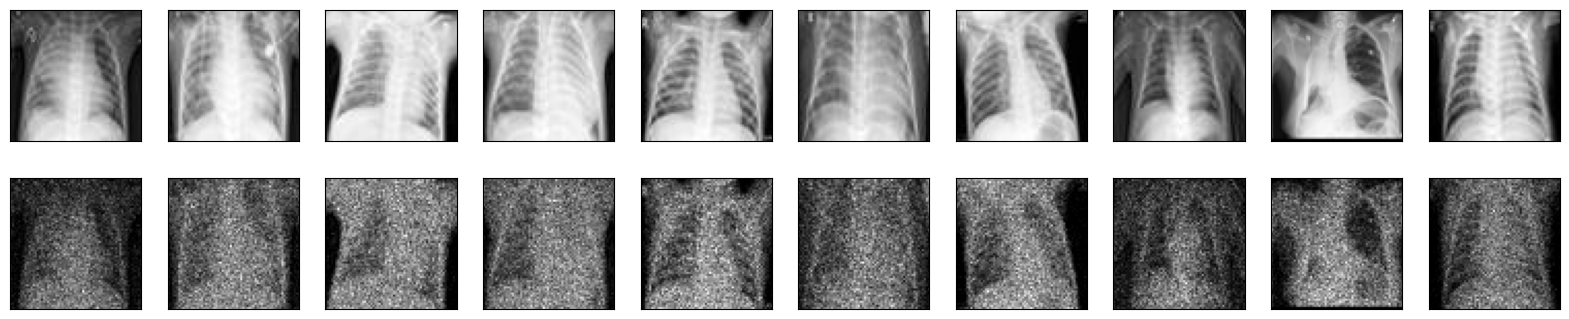

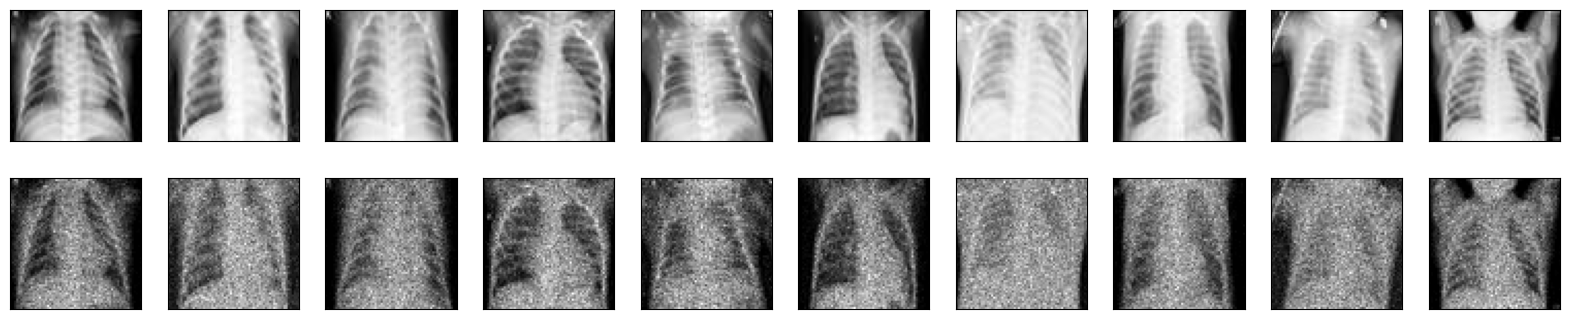

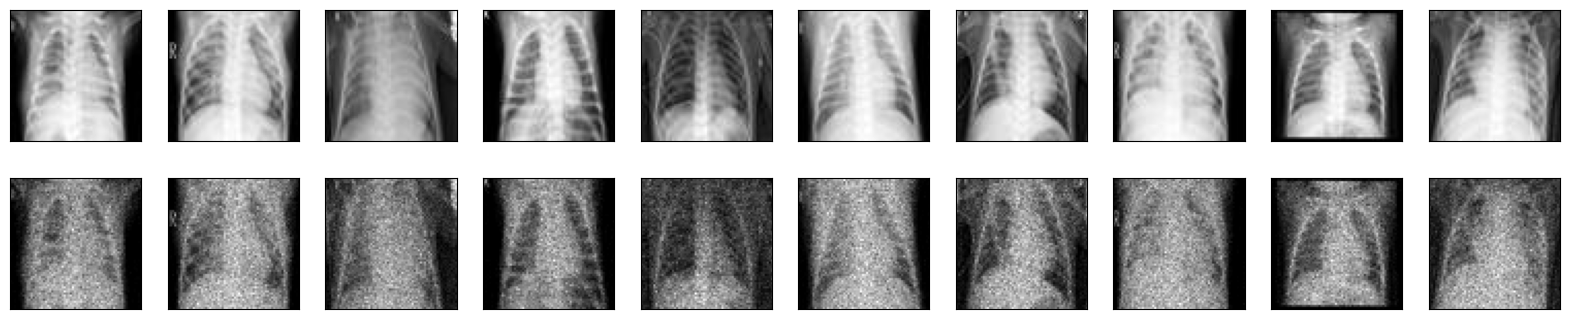

In [10]:
import os
import numpy as np
from keras.datasets import mnist
from keras.preprocessing import image




print('Importing images...')
train_data = []
train_image_names = os.listdir('../submission-2-denoising-autoencoders/train')
for i in range(len(train_image_names)):
    img = image.load_img(
        '../submission-2-denoising-autoencoders/train/' + train_image_names[i]
        , target_size=(64,64), color_mode= 'grayscale')
    img = image.img_to_array(img)
    img = img / 255
    train_data.append(img)

train_data = np.array(train_data)
print("Finished importing train images")

# import images from ./test
test_data = []
test_image_names = os.listdir('../submission-2-denoising-autoencoders/test')


# Max 10 images
for i in range(len(test_image_names)):
    img = image.load_img(
        '../submission-2-denoising-autoencoders/test/' + test_image_names[i]
        , target_size=(64,64), color_mode= 'grayscale')
    img = image.img_to_array(img)
    img = img / 255
    test_data.append(img)
    

test_data = np.array(test_data)
print("Finished importing test images")



# Normalize and reshape the data

# Create a copy of the data with added noise
noisy_train_data_25 = noise(train_data, 25)
noisy_test_data_25 = noise(test_data, 25)

noisy_train_data_50 = noise(train_data, 50)
noisy_test_data_50 = noise(test_data, 50)

noisy_train_data_75 = noise(train_data, 75)
noisy_test_data_75 = noise(test_data, 75)

# # Display the train data and a version of it with added noise

display(train_data, noisy_train_data_25)
display(train_data, noisy_train_data_50)
display(train_data, noisy_train_data_75)



In [11]:


input = layers.Input(shape=(64, 64, 1))

# Encoder
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

encoded = x

# Decoder
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

encoder = Model(input, encoded)
encoder.summary()

def encode(image):
    # Normalize and reshape the image as needed, then pass it through the encoder
    latent_vector = encoder.predict(image)
    return latent_vector



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_transpose (Conv2DTr  (None, 32, 32, 64)        36928 

In [12]:
autoencoder.fit(
    x=train_data,
    y=train_data,
    shuffle=True,
		epochs=10,
		batch_size=10,
    validation_data=(test_data, test_data),
)

Epoch 1/10
 69/185 [==========>...................] - ETA: 4s - loss: 0.6201

KeyboardInterrupt: 

15/15 [==============================] - 1s 34ms/step


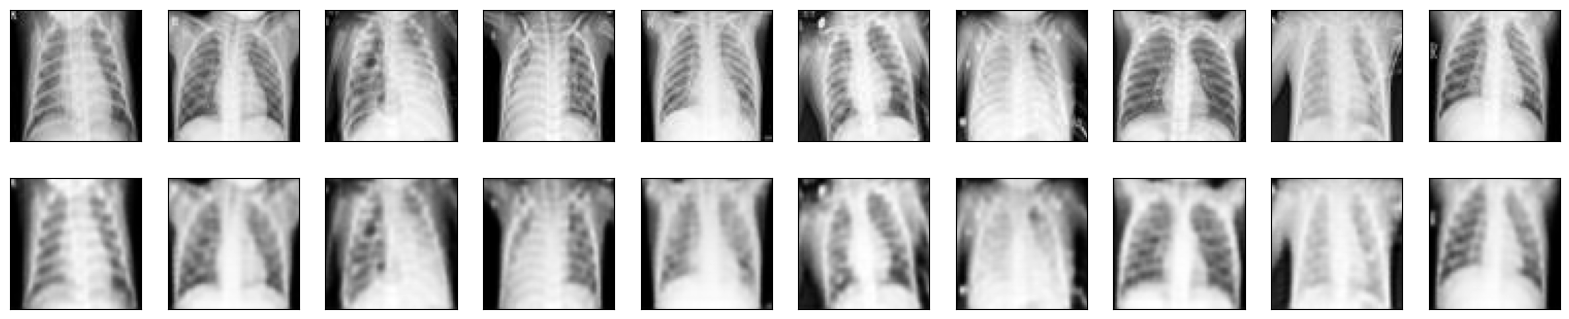

In [9]:
predictions = autoencoder.predict(test_data)
display(test_data, predictions)

In [10]:
# Lambda 25
autoencoder.fit(
    x=noisy_train_data_25,
    y=train_data,
    epochs=100,
    batch_size=10,
    shuffle=True,
    validation_data=(noisy_test_data_25, test_data),
)

Epoch 1/100
185/185 [==============================] - 9s 47ms/step - loss: 0.5731 - val_loss: 0.5732
Epoch 2/100
185/185 [==============================] - 8s 46ms/step - loss: 0.5721 - val_loss: 0.5732
Epoch 3/100
185/185 [==============================] - 8s 45ms/step - loss: 0.5720 - val_loss: 0.5732
Epoch 4/100
185/185 [==============================] - 8s 45ms/step - loss: 0.5720 - val_loss: 0.5730
Epoch 5/100
185/185 [==============================] - 8s 45ms/step - loss: 0.5718 - val_loss: 0.5728
Epoch 6/100
185/185 [==============================] - 8s 45ms/step - loss: 0.5718 - val_loss: 0.5729
Epoch 7/100
185/185 [==============================] - 8s 45ms/step - loss: 0.5718 - val_loss: 0.5727
Epoch 8/100
185/185 [==============================] - 8s 46ms/step - loss: 0.5717 - val_loss: 0.5727
Epoch 9/100
185/185 [==============================] - 9s 46ms/step - loss: 0.5717 - val_loss: 0.5731
Epoch 10/100
185/185 [==============================] - 9s 47ms/step - loss: 0.571

15/15 [==============================] - 1s 33ms/step


<Figure size 2000x400 with 0 Axes>

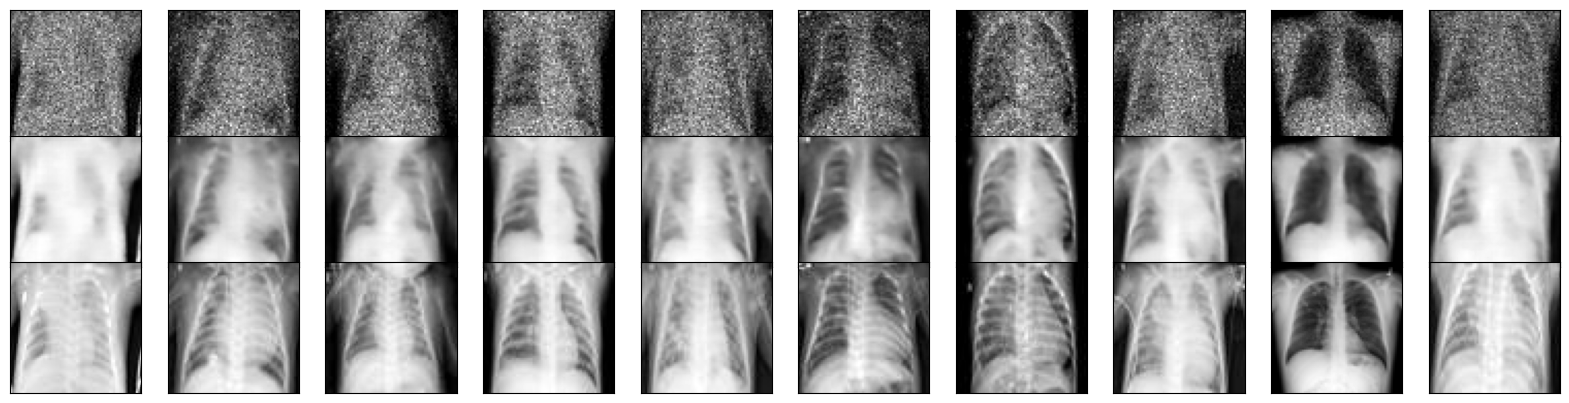

Lambda 25
Average SSIM:  0.8219505444144336
Average SSIM with mean filter:  0.08629638814887965
Average SSIM with gaussian blur:  0.1738577900133593
Average SSIM with median filter:  0.1374091657484389
Average SSIM with bilateral filter:  0.5557363674359882


In [11]:
predictions = autoencoder.predict(noisy_test_data_25)

scores_25 = []
for i in range(len(predictions)):
	scores_25.append(calculate_similarity(test_data[i], predictions[i]))


res_mean_25 = get_average_score(noisy_test_data_25, apply_mean_filter)
res_gauss_25 = get_average_score(noisy_test_data_25, apply_gaussian_blur)
res_median_25 = get_average_score(noisy_test_data_25, apply_median_filter)
res_bi_25 = get_average_score(noisy_test_data_25, apply_bilateral_filter)

display(noisy_test_data_25, predictions, test_data)

print("Lambda 25")
print("Average SSIM: ", sum(scores_25) / len(scores_25))
print("Average SSIM with mean filter: ", res_mean_25[0])
print("Average SSIM with gaussian blur: ", res_gauss_25[0])
print("Average SSIM with median filter: ", res_median_25[0])
print("Average SSIM with bilateral filter: ", res_bi_25[0])



### Lambda 50

In [21]:

autoencoder.fit(
    x=noisy_train_data_50,
    y=train_data,
    epochs=100,
    batch_size=10,
    shuffle=True,
    validation_data=(noisy_test_data_50, test_data),
)

Epoch 1/100
185/185 [==============================] - 9s 47ms/step - loss: 0.5907 - val_loss: 0.5752
Epoch 2/100
185/185 [==============================] - 8s 45ms/step - loss: 0.5735 - val_loss: 0.5737
Epoch 3/100
185/185 [==============================] - 8s 44ms/step - loss: 0.5726 - val_loss: 0.5732
Epoch 4/100
185/185 [==============================] - 8s 45ms/step - loss: 0.5722 - val_loss: 0.5729
Epoch 5/100
185/185 [==============================] - 8s 46ms/step - loss: 0.5720 - val_loss: 0.5727
Epoch 6/100
185/185 [==============================] - 8s 46ms/step - loss: 0.5717 - val_loss: 0.5726
Epoch 7/100
185/185 [==============================] - 9s 49ms/step - loss: 0.5715 - val_loss: 0.5726
Epoch 8/100
185/185 [==============================] - 11s 58ms/step - loss: 0.5714 - val_loss: 0.5723
Epoch 9/100
185/185 [==============================] - 9s 50ms/step - loss: 0.5713 - val_loss: 0.5722
Epoch 10/100
185/185 [==============================] - 9s 47ms/step - loss: 0.57

15/15 [==============================] - 1s 33ms/step


<Figure size 2000x400 with 0 Axes>

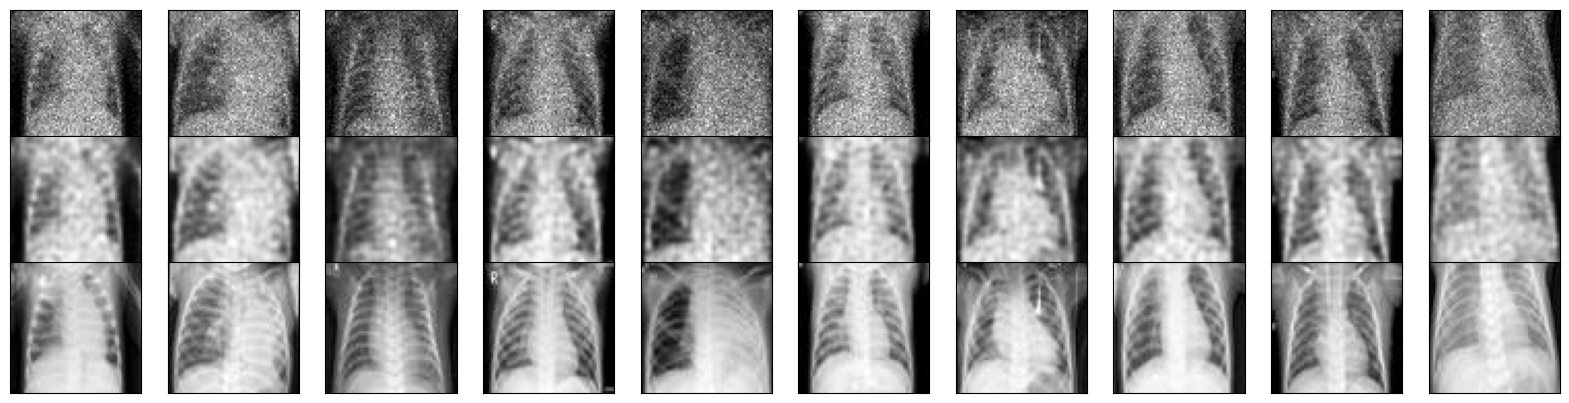

Lambda 50
Average SSIM:  0.758386654785561
Average SSIM with mean filter:  0.10846537606508244
Average SSIM with gaussian blur:  0.22341369100739378
Average SSIM with median filter:  0.17712848565609302
Average SSIM with bilateral filter:  0.5735974019750897


In [11]:

predictions = autoencoder.predict(noisy_test_data_50)

scores_50 = []
for i in range(len(predictions)):
	scores_50.append(calculate_similarity(test_data[i], predictions[i]))


res_mean_50 = get_average_score(noisy_test_data_50, apply_mean_filter)
res_gauss_50 = get_average_score(noisy_test_data_50, apply_gaussian_blur)
res_median_50 = get_average_score(noisy_test_data_50, apply_median_filter)
res_bi_50 = get_average_score(noisy_test_data_50, apply_bilateral_filter)

display(noisy_test_data_50, predictions, test_data)

print("Lambda 50")
print("Average SSIM: ", sum(scores_50) / len(scores_50))
print("Average SSIM with mean filter: ", res_mean_50[0])
print("Average SSIM with gaussian blur: ", res_gauss_50[0])
print("Average SSIM with median filter: ", res_median_50[0])
print("Average SSIM with bilateral filter: ", res_bi_50[0])



### Lambda = 75

In [19]:

autoencoder.fit(
    x=noisy_train_data_75,
    y=train_data,
    epochs=100,
    batch_size=10,
    shuffle=True,
    validation_data=(noisy_test_data_75, test_data),
)

Epoch 1/100
185/185 [==============================] - 8s 45ms/step - loss: 0.5693 - val_loss: 0.5703
Epoch 2/100
185/185 [==============================] - 8s 44ms/step - loss: 0.5692 - val_loss: 0.5703
Epoch 3/100
185/185 [==============================] - 8s 44ms/step - loss: 0.5692 - val_loss: 0.5703
Epoch 4/100
185/185 [==============================] - 8s 44ms/step - loss: 0.5692 - val_loss: 0.5704
Epoch 5/100
185/185 [==============================] - 8s 45ms/step - loss: 0.5692 - val_loss: 0.5703
Epoch 6/100
185/185 [==============================] - 8s 45ms/step - loss: 0.5692 - val_loss: 0.5703
Epoch 7/100
185/185 [==============================] - 8s 45ms/step - loss: 0.5692 - val_loss: 0.5703
Epoch 8/100
185/185 [==============================] - 8s 45ms/step - loss: 0.5692 - val_loss: 0.5704
Epoch 9/100
185/185 [==============================] - 9s 46ms/step - loss: 0.5692 - val_loss: 0.5703
Epoch 10/100
185/185 [==============================] - 8s 46ms/step - loss: 0.569

15/15 [==============================] - 1s 35ms/step


<Figure size 2000x400 with 0 Axes>

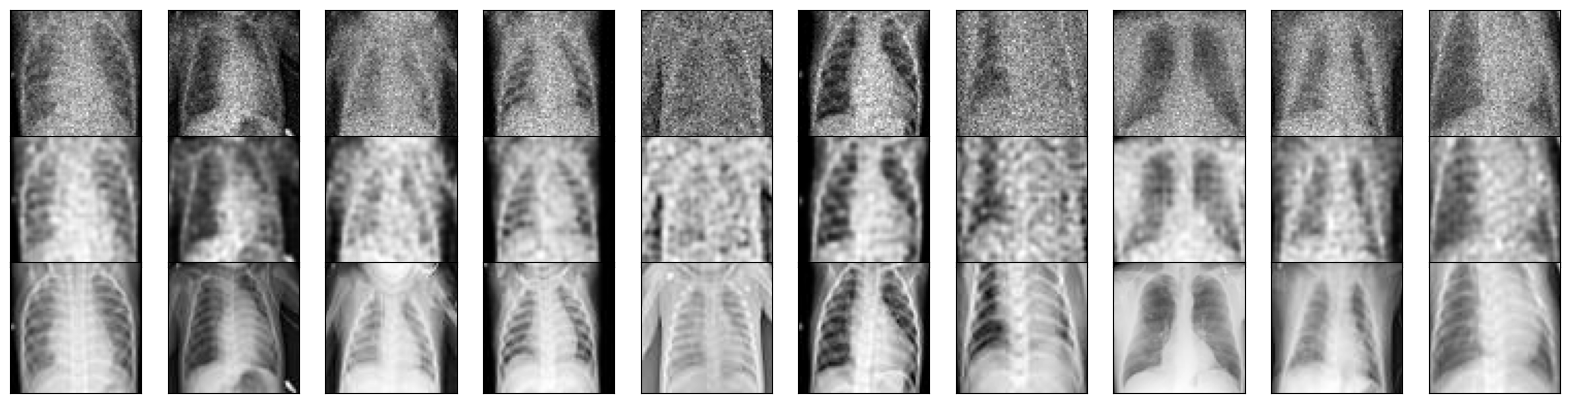

Lambda 75
Average SSIM:  0.758386654785561
Average SSIM with mean filter:  0.1247727661133378
Average SSIM with gaussian blur:  0.2556605982448749
Average SSIM with median filter:  0.20144736501107843
Average SSIM with bilateral filter:  0.5839701918997732


In [12]:

predictions = autoencoder.predict(noisy_test_data_50)

scores_75 = []
for i in range(len(predictions)):
	scores_75.append(calculate_similarity(test_data[i], predictions[i]))


res_mean_75 = get_average_score(noisy_test_data_75, apply_mean_filter)
res_gauss_75 = get_average_score(noisy_test_data_75, apply_gaussian_blur)
res_median_75 = get_average_score(noisy_test_data_75, apply_median_filter)
res_bi_75 = get_average_score(noisy_test_data_75, apply_bilateral_filter)

display(noisy_test_data_75, predictions, test_data)

print("Lambda 75")
print("Average SSIM: ", sum(scores_75) / len(scores_75))
print("Average SSIM with mean filter: ", res_mean_75[0])
print("Average SSIM with gaussian blur: ", res_gauss_75[0])
print("Average SSIM with median filter: ", res_median_75[0])
print("Average SSIM with bilateral filter: ", res_bi_75[0])



In [12]:
from beautifultable import BeautifulTable

table = BeautifulTable()
table.set_style(BeautifulTable.STYLE_MARKDOWN)
table.column_headers = ["","Lambda = 25", "Lambda = 50", "Lambda = 75"]

table.append_row([
	"Median Filter",
	res_median_25[0],
	res_median_50[0],
	res_median_75[0],
])

table.append_row([
	"Mean Filter",
	res_mean_25[0],
	res_mean_50[0],
	res_mean_75[0],
])

table.append_row([
	"Gaussian Blur",
	res_gauss_25[0],
	res_gauss_50[0],
	res_gauss_75[0],
])

table.append_row([
	"Bilateral Filter",
	res_bi_25[0],
	res_bi_50[0],
	res_bi_75[0],
])

table.append_row([
	"Autoencoder",
	sum(scores_25) / len(scores_25),
	sum(scores_50) / len(scores_50),
	sum(scores_75) / len(scores_75),
])



print(table)


/Users/paolotiu/Desktop/code/school/ISCS30.65/venv/lib/python3.11/site-packages/beautifultable/utils.py:125: FutureWarning: 'BeautifulTable.column_headers' has been deprecated in 'v1.0.0' and will be removed in 'v1.2.0'. Use 'BTColumnCollection.header' instead.
  warnings.warn(message, FutureWarning)


NameError: name 'res_median_50' is not defined

|                  | Lambda = 25 | Lambda = 50 | Lambda = 75 |
|------------------|-------------|-------------|-------------|
|  Median Filter   |    0.137    |    0.178    |    0.202    |
|   Mean Filter    |    0.086    |    0.11     |    0.125    |
|  Gaussian Blur   |    0.173    |    0.224    |    0.256    |
| Bilateral Filter |    0.554    |    0.574    |    0.585    |
|   Autoencoder    |    0.804    |    0.865    |    0.865    |


a) Why is poisson distribution the ideal one to use to simulate noise for medical images? Why not gaussian or something else? Answer in terms of relevance of medical applications.


The method which x-ray images are captured is by using a detector that counts the number of photons that hit the detector. The emission of the photons from the X-ray source is a Poisson process, so using a poisson distrubution to sumulate noise is better for this case. 


b) Which one performed the best? Why do you think this is the case?

The autoencoder performed the best. This is because the autoencoder is trained specifically to denoise the x-ray images. The other filters meanwhile are not trained to denoise x-ray images. They are more general filters that are used to denoise images in general.


In [13]:
import pandas as pd

z_values = encode(train_data)

# Conveert to 2-d
z_values = z_values.reshape(z_values.shape[0], -1)

# Convert the list of z values into a DataFrame
z_df = pd.DataFrame(z_values)

# Save the DataFrame to a .csv file
z_df.to_csv('z_values.csv', index=False)


58/58 [==============================] - 1s 12ms/step


In [13]:
print(autoencoder.layers[4].output)

KerasTensor(type_spec=TensorSpec(shape=(None, 16, 16, 64), dtype=tf.float32, name=None), name='max_pooling2d_1/MaxPool:0', description="created by layer 'max_pooling2d_1'")


In [14]:
# Assuming `autoencoder` is your trained model and `x_val` is your validation set
from sklearn.metrics import mean_squared_error


reconstructed_images = autoencoder.predict(test_data)
vals = [mean_squared_error(test_data[i].flatten(), reconstructed_images[i].flatten()) for i in range(len(test_data))]
mse = np.mean(vals)

mse

15/15 [==============================] - 1s 34ms/step


0.0039673294

In [16]:
print("MSE: ", mse)

MSE:  0.0039673294


For this particular task,  how did you measure how good your configuration for latent space dimensionality is? Make sure your answer follows the following criteria:

Objectively sound (computationally proven)
Explainable

I measured how good my configuration for latent space dimensionality is by using Mean Squared Error (MSE) and Structural Similarity Index (SSIM). I used these two metrics because they are both computationally proven and explainable. The MSE measures the average squared difference between the original and the denoised image. 